# Data Preprocessing

In [58]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1d'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1d', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

dir_  = pd.Series(
    np.where(ret1 >= 0, 1, 0),
    index=ret1.index,
    name='dir'
)

# delta = 0.001                       # 0.1 % threshold
# dir_  = pd.Series(
#     np.where(ret1 >  delta,  2,
#     np.where(ret1 < -delta, 0, 1)),
#     index=ret1.index,
#     name='dir'
# )

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
0    668
1    655
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-07,52586.77,52818.37,43000.00,46729.20,645.126118,18.635134,193.171459,1185.709987,2640.824360,-0.227866,-0.849630,1.0,95818.37,1.228334,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.271190e+09,9818.37,1435656.54,1.570775,46730.0,0.407693,46729.0,10.752125,4.669588,0.913119,216.169378,2.239724,28.294841,33.776386,919.061795,100.000000,100.000000,0.0,-0.596593,-82.288544,-4.450960,22.825941,1588.845268,1844.472121,-255.626853,919.061795,1182.885726,-263.823932,1517.644555,1762.038593,-244.394038,59.821484,29.733322,10900.650538,-2155.64,18.682056,6849.102442,1.905808,-4.409629,-0.044096,0.955904,95.590371,47.774520,78.052107,84.235899,37.981865,78.052107,0.000000,66.666667,56.246084,-62.018135,54207.512275,50187.278,46167.043725,51260.777269,47019.503009,48206.442387,47599.349994,47855.218000,48169.377335,47496.809775,49657.985,47909.185,52818.370000,-52818.370000,47855.218000,50338.783665,47942.271542,48607.124688,0.0,0.0,0.0,0.0,0.0,-80.0,0.0,0.0,0.0,0.0,0.0,0.0,-200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48783.5850,47909.185,47515.856667,47319.1925,1.280292,0.687029,50108.163714,89.673638,47825.924857,175.556835,2010.117137,50283.720549,4.040571e+06,2620.988328,5.608888,9818.37,1103.680104,133.580534,1048.136021,-0.111389,0
2021-09-08,46729.20,47299.87,44436.94,46014.25,407.756328,18.475897,197.380038,1927.090095,1588.805912,-0.298708,-0.886042,1.0,91736.81,1.064427,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.101861e+09,2862.93,1435385.46,1.570775,46015.0,-0.791463,46014.0,10.736706,4.662892,0.611217,214.509324,-0.772262,27.904205,32.846811,736.058462,92.857143,92.857143,0.0,-0.249727,-147.476793,-8.106458,22.825941,1218.622897,1719.302276,-500.679379,736.058462,1065.713903,-329.655442,1168.501409,1643.331156,-474.829747,51.103176,27.426780,10122.032642,-2742.33,17.232809,6359.880839,1.528511,-5.624533,-0.056245,0.943755,94.375467,45.946771,55.639083,74.829356,30.700106,55.639083,0.000000,33.333333,53.55

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

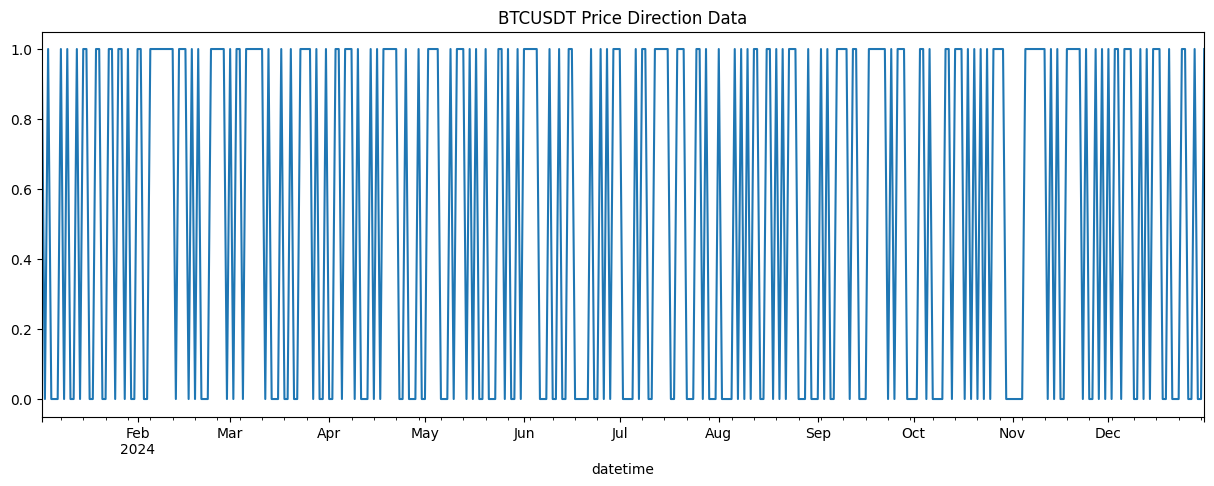

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2024-01-01') & (df_all.index < '2025-01-01')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Machine Learning 

# Feature Engineering and Selection

## Scaling

In [60]:
import pandas as pd, numpy as np
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
KEEP_PCT    = 0.30

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# 2) build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# 3) Apply Robust standardization to features(X) ────────────────────────
scaler = RobustScaler()
X_lag_scaled = pd.DataFrame(scaler.fit_transform(X_lag),index=X_lag.index,columns=X_lag.columns)

## Parameter Optimization

In [61]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import log_loss

# # 1) set up your grid (or use random.sample on ParameterGrid for a cheap random search)
# param_grid = {
#     'max_depth':       [3, 5, 7],
#     'learning_rate':   [0.001, 0.01],
#     'subsample':       [0.5, 0.7, 1],
#     'colsample_bytree':[0.5, 0.7, 1],
#     'gamma':           [0.],
#     'min_child_weight':[1, 3, 5, 7],
#     'reg_alpha':       [0, 0.5, 1, 1.5],
#     'reg_lambda':      [0, 0.5, 1, 1.5],
# }

# best_score = np.inf
# best_params = None

# for params in ParameterGrid(param_grid):
#     fold_scores = []
#     for train_idx, val_idx in tss.split(X):
#         X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
#         X_va, y_va = X.iloc[val_idx], y.iloc[val_idx]

#         clf = XGBClassifier(
#             objective='binary:logistic',
#             eval_metric='logloss',
#             random_state=42,
#             n_jobs=-1,
#             early_stopping_rounds=50,
#             n_estimators=10000,
#             **params
#         )
#         clf.fit(
#             X_tr, y_tr,
#             eval_set=[(X_va, y_va)],
#             verbose=False
#         )

#         # record logloss on this fold’s best iteration
#         proba = clf.predict_proba(X_va)[:, 1]
#         fold_scores.append(log_loss(y_va, proba))

#     mean_score = np.mean(fold_scores)
#     if mean_score < best_score:
#         best_score, best_params = mean_score, params
#         print(f"New best: {best_score:.5f} with {best_params}")

# print("▶ Final best logloss:", best_score)
# print("▶ Final best params:", best_params)


## Train, Test Split

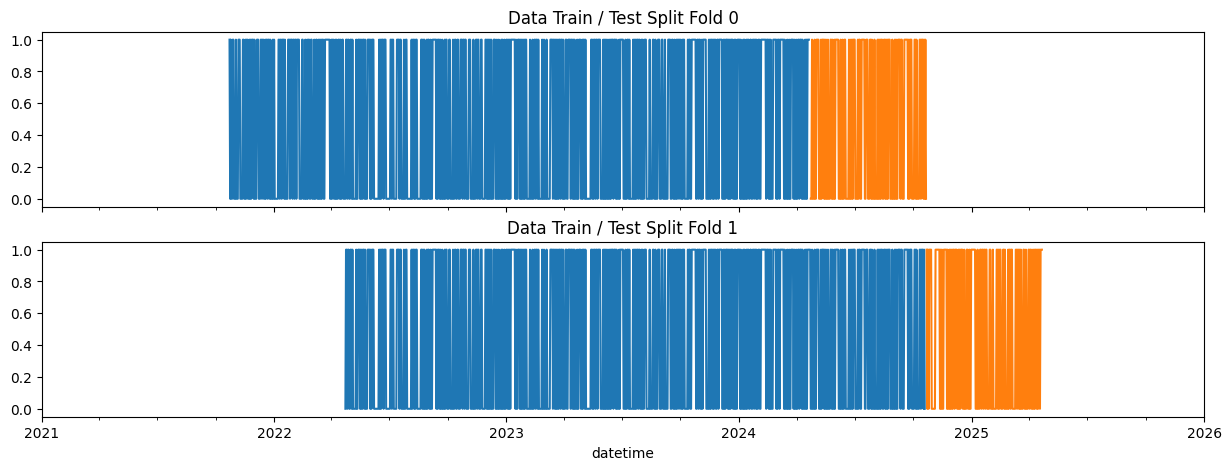

In [62]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Prepare X and y
X = X_lag_scaled.copy()   
y = y.copy()

# TimeSeriesSplit
n_splits = 2
train_window_size = int(365*2.5)
val_window_size = int(365/2)
train_val_gap = 1
tss = TimeSeriesSplit(n_splits, test_size=val_window_size, gap=train_val_gap)

fig, axs = plt.subplots(n_splits,1,figsize=(15,5),sharex=True)
fold = 0
for train_idx, val_idx in tss.split(X):
    train_idx = train_idx[-train_window_size:-1]

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    y_train.plot(ax=axs[fold], label='Training set', title=f'Data Train / Test Split Fold {fold}')
    y_val.plot(ax=axs[fold], label='Test Set')
    fold += 1
    
for ax in axs:
    ax.set_xlim('2021-01-01', '2026-01-01')
plt.show()

## Model Fitting

In [63]:
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

preds = {}
probs = {}
vals = {}
fis = {}

# Set up a RandomForest for BorutaPy
rf_proto = RandomForestClassifier(
    n_estimators='auto',        # BorutaPy will actually override this with 'auto'
    max_depth=7,
    n_jobs=-1,
    random_state=42
)

# Wrap in BorutaPy
boruta_proto = BorutaPy(
    estimator=rf_proto,
    n_estimators='auto',        # let Boruta pick a sufficient forest size
    verbose=False,              # shows you progress of the shadow‐feature tests
    random_state=42,
)

clf_proto = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    # use_label_encoder=False,
    random_state=42,
    n_jobs=-1,

    # Complexity control
    n_estimators=10000,          # start big, prune with ES
    early_stopping_rounds=25,   # stop if no val-loss improvement for 50 rounds
    max_depth=7,                # shallow trees generalize better
    learning_rate=0.01,         # smaller step size → smoother fit
    subsample=0.5,              # row sampling
    colsample_bytree=1.,       # feature sampling

    # Split regularization
    gamma=0.,                  # min loss reduction to make a split
    min_child_weight=7,         # min sum hessian in a leaf

    # Weight regularization
    reg_alpha=1.,              # L1
    reg_lambda=1.5,             # L2
)

for fold, (train_idx, val_idx) in enumerate(tss.split(X_lag_scaled)):

    rf = clone(rf_proto)
    boruta = clone(boruta_proto)
    clf = clone(clf_proto)

    print(f'================== fold {fold} ==================')

    X_train = X_lag_scaled.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X_lag_scaled.iloc[val_idx]
    y_val = y.iloc[val_idx]

    # 1) Feature Selection - Mutual Information
    # 1) avg MI over folds ──────────────────────────────────────────────────
    mi = pd.Series(0.0, index=X_train.columns)
    mi  += mutual_info_classif(X_train, y_train, discrete_features=False)
    mi /= n_splits

    # 2) keep top KEEP_PCT of lags ──────────────────────────────────────────
    k = max(1, int(len(mi) * KEEP_PCT))
    top_feats = mi.nlargest(k).index
    X_train_mi = X_train[top_feats]
    X_val_mi = X_val[top_feats]

    # 3) Fit on your training data ------------------------------------------
    # Pass the raw values; BorutaPy does its own internal shadow‐feature testing
    boruta.fit(X_train_mi.values, y_train.values)

    # 4) Extract and rank all features by Boruta rank ------------------------
    # boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
    ranks = pd.Series(boruta.ranking_, index=X_train_mi.columns)

    # 5) Sort ascending (1 = best), then take the top 10 names
    boruta_selected = ranks.sort_values().head(10).index.tolist()
    X_train_sel = X_train_mi[boruta_selected]
    X_val_sel = X_val.reindex(columns=boruta_selected)

    print("Top 10 features by Boruta rank:")
    for i, feat in enumerate(boruta_selected, 1):
        print(f"{i:2d}. {feat} (rank={ranks[feat]})")

    clf.fit(
        X_train_sel, y_train,
        eval_set=[(X_train_sel, y_train), (X_val_sel, y_val)],
        verbose=100,
    )

    # Result Collection
    preds[fold]= clf.predict(X_val_sel)
    probs[fold] = clf.predict_proba(X_val_sel)
    vals[fold] = y_val
    fis[fold] = {'feature_importances_': clf.feature_importances_, 'feature_names_in_': clf.feature_names_in_}

================== fold 0 ==================
Top 10 features by Boruta rank:
 1. STOCHF_fastk_lag1 (rank=1)
 2. DIV_real_lag5 (rank=2)
 3. BOP_real_lag1 (rank=2)
 4. STOCH_slowd_lag13 (rank=3)
 5. ret1_lag9 (rank=4)
 6. TAN_real_lag7 (rank=5)
 7. COS_real_lag14 (rank=6)
 8. ret1_lag5 (rank=7)
 9. TAN_real_lag5 (rank=8)
10. HT_SINE_leadsine_lag5 (rank=10)
[0]	validation_0-logloss:0.69259	validation_1-logloss:0.69261
[81]	validation_0-logloss:0.65018	validation_1-logloss:0.68605
================== fold 1 ==================
Top 10 features by Boruta rank:
 1. DIV_real_lag5 (rank=1)
 2. STOCHF_fastk_lag1 (rank=2)
 3. ret1_lag5 (rank=3)
 4. ret1_lag9 (rank=4)
 5. TAN_real_lag5 (rank=5)
 6. HT_SINE_leadsine_lag5 (rank=6)
 7. DX_real_lag1 (rank=7)
 8. SIN_real_lag6 (rank=8)
 9. SIN_real_lag3 (rank=9)
10. ret1_lag2 (rank=10)
[0]	validation_0-logloss:0.69254	validation_1-logloss:0.69345
[100]	validation_0-logloss:0.64143	validation_1-logloss:0.68372
[146]	validation_0-logloss:0.62244	validation

# Result

## Feature Importance

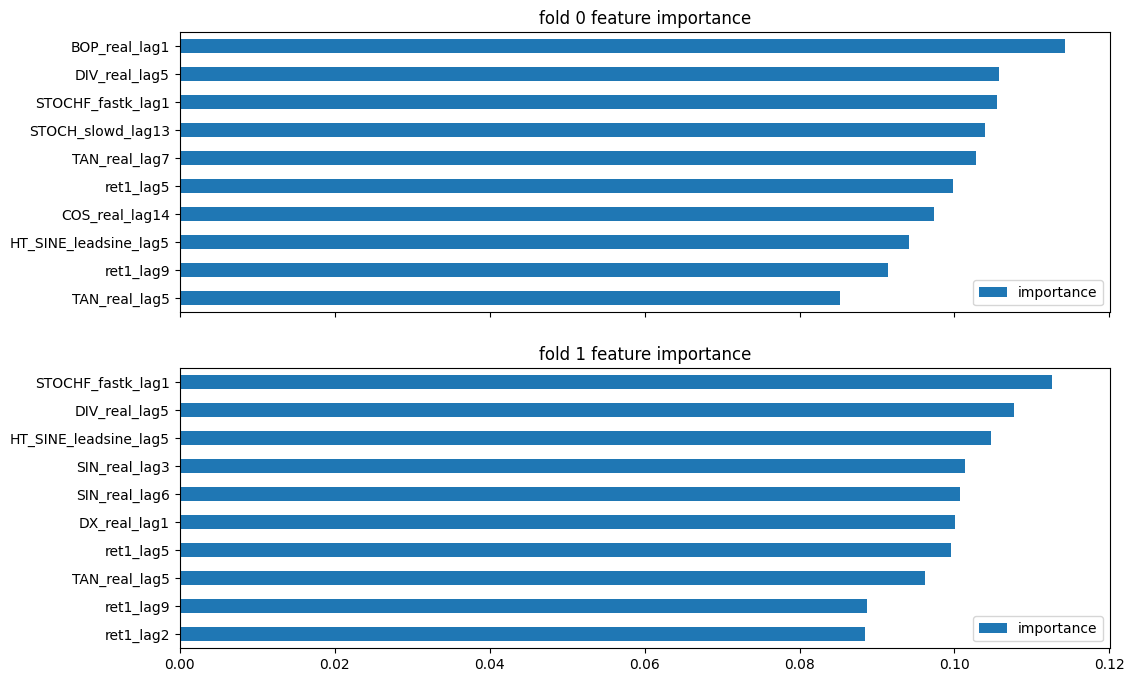

In [64]:
fig, axs = plt.subplots(n_splits,1,figsize=(12,8),sharex=True)

for fold in range(n_splits):
    fi = pd.DataFrame(data = fis[fold]['feature_importances_'],
                      index = fis[fold]['feature_names_in_'],
                      columns = ['importance'])
    fi.sort_values('importance').plot(ax=axs[fold], title=f'fold {fold} feature importance', kind='barh')
    
plt.show()

## Model Evaluation

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


for fold in range(n_splits):
    # 1) Recall predicted and actual y outputs
    y_pred = preds[fold]
    y_val = vals[fold]

    # 2) Compute accuracy
    val_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # 3) (Optional) More diagnostics
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

Validation accuracy: 0.5934

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.69      0.64        94
           1       0.60      0.49      0.54        88

    accuracy                           0.59       182
   macro avg       0.59      0.59      0.59       182
weighted avg       0.59      0.59      0.59       182


Confusion Matrix:
[[65 29]
 [45 43]]
Validation accuracy: 0.5659

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.65      0.59        89
           1       0.59      0.48      0.53        93

    accuracy                           0.57       182
   macro avg       0.57      0.57      0.56       182
weighted avg       0.57      0.57      0.56       182


Confusion Matrix:
[[58 31]
 [48 45]]


## Model Evaluation with probability threshold

In [82]:
threshold = 0.54

for fold in range(n_splits):
    print(f'================== fold {fold} ==================')

    y_proba = probs[fold]
    y_proba = y_proba.max(axis=1)

    y_pred = preds[fold]
    y_val = vals[fold]

    y_pred_confident = y_pred[y_proba>threshold]
    y_test_confident = y_val[y_proba>threshold]


    # 2) Compute accuracy
    if len(y_pred_confident) != 0:
        val_accuracy = accuracy_score(y_test_confident, y_pred_confident)
        print(f"Validation accuracy: {val_accuracy:.4f}")

        print(f"percentage of trade occured per 6h data: {len(y_test_confident)/len(y_val)*100:.3}%")

        # 3) (Optional) More diagnostics
        print("\nClassification Report:")
        print(classification_report(y_test_confident, y_pred_confident))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test_confident, y_pred_confident))

================== fold 0 ==================
Validation accuracy: 0.5385
percentage of trade occured per 6h data: 21.4%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.62        21
           1       0.50      0.33      0.40        18

    accuracy                           0.54        39
   macro avg       0.53      0.52      0.51        39
weighted avg       0.53      0.54      0.52        39


Confusion Matrix:
[[15  6]
 [12  6]]
================== fold 1 ==================
Validation accuracy: 0.5977
percentage of trade occured per 6h data: 47.8%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.65        42
           1       0.67      0.44      0.53        45

    accuracy                           0.60        87
   macro avg       0.61      0.60      0.59        87
weighted avg       0.62      0.60      0.59        87


Confusion Matrix:
[

## Trading Performance Metrics

================== fold 0 ==================
Backtest:     2024-04-27 → 2024-10-16
Trades:       39
Win rate:     53.85%
Avg win:      0.0178
Avg loss:     -0.0145
Expectancy:   0.0029
Profit factor:1.43
Calmar ratio: 3.61

Total return:  11.01%
Annual return:24.82%
Annual vol:    199.04%
Sharpe ratio: 0.12
Max drawdown:  -6.88%

Initial cap:  10000.00 USDT
Final cap:    11101.05 USDT
Abs. profit:  1101.05 USDT


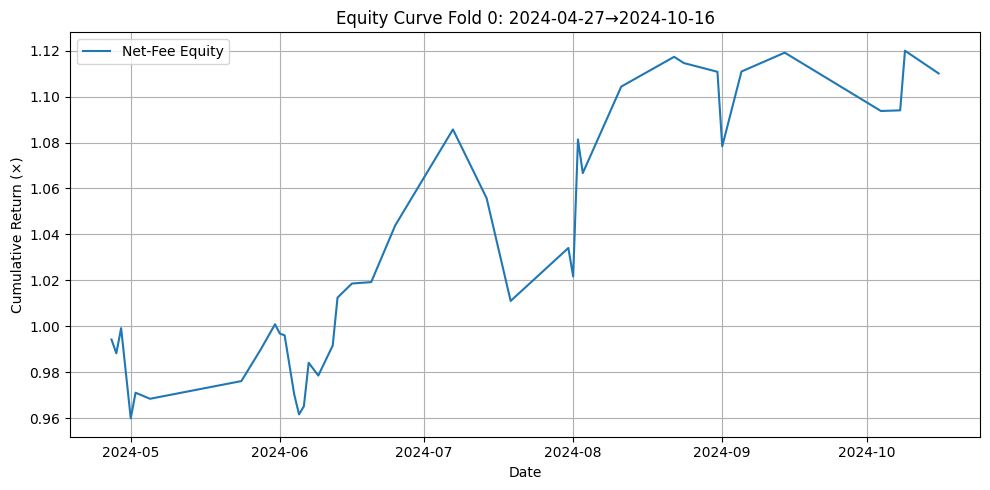

================== fold 1 ==================
Backtest:     2024-10-23 → 2025-04-21
Trades:       87
Win rate:     56.32%
Avg win:      0.0199
Avg loss:     -0.0159
Expectancy:   0.0042
Profit factor:1.61
Calmar ratio: 7.44

Total return:  40.97%
Annual return:100.64%
Annual vol:    224.36%
Sharpe ratio: 0.45
Max drawdown:  -13.52%

Initial cap:  11101.05 USDT
Final cap:    15649.45 USDT
Abs. profit:  4548.40 USDT


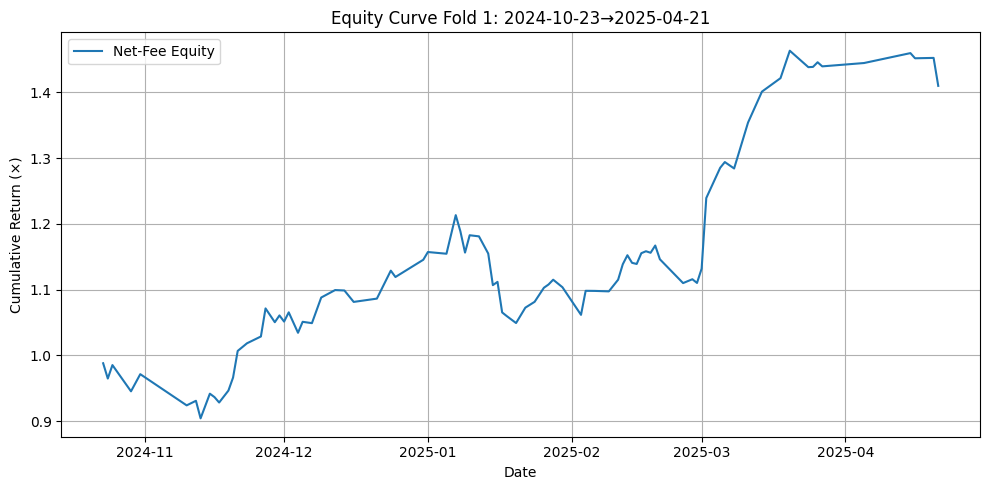

In [84]:
# parameters
fee_per_trade = 0.00075      # e.g. 0.05% per entry AND exit → 2*fee_per_trade per round-trip
initial_cap = 10000.0

for fold in range(n_splits):
    print(f'================== fold {fold} ==================')
    
    # ─── 1) filter “confident” signals ────────────────────────────────────────
    y_proba = probs[fold].max(axis=1)
    y_pred  = pd.Series(preds[fold], index=vals[fold].index)
    y_true  = vals[fold]
    
    mask = y_proba > threshold
    y_pred_conf = y_pred[mask]
    y_true_conf = y_true[mask]
    idx_conf    = y_true_conf.index

    if len(y_pred_conf) != 0:
        
        # ─── 2) build trade returns series ────────────────────────────────────────
        # for each timestamp, long=1 → ret1, short=0 → -ret1
        returns = df_all.loc[idx_conf, "ret1"]
        trade_ret = np.where(y_pred_conf==1, returns, -returns)
        # subtract fees on entry+exit
        trade_net = trade_ret - fee_per_trade
        
        # turn into an equity curve (starts at 1.0)
        equity  = pd.Series((1 + trade_net).cumprod(), index=idx_conf)
        fee_ret = pd.Series(trade_net,                index=idx_conf)
        
        # ─── 3) performance metrics ────────────────────────────────────────────────
        wins   = trade_net[trade_net > 0]
        losses = trade_net[trade_net <= 0]
        n_trades = len(trade_net)
        
        # time-based
        start_date = equity.index[0]
        end_date   = equity.index[-1]
        days       = max((end_date - start_date).days, 1)
        
        total_ret = equity.iloc[-1] - 1
        ann_ret   = equity.iloc[-1]**(365.0/days) - 1
        ann_vol   = fee_ret.std() * np.sqrt(24 * 365)   # if hourly data
        sharpe    = ann_ret / ann_vol if ann_vol else np.nan
        mdd       = ((equity - equity.cummax())/equity.cummax()).min()
        
        # trade-based
        win_rate      = len(wins) / n_trades if n_trades else np.nan
        avg_win       = wins.mean() if len(wins) else np.nan
        avg_loss      = losses.mean() if len(losses) else np.nan
        profit_factor = wins.sum() / (-losses.sum()) if losses.sum() != 0 else np.nan
        expectancy    = trade_net.mean() if n_trades else np.nan
        calmar        = ann_ret / abs(mdd) if mdd < 0 else np.nan
        
        # absolute P&L on 200 USDT
        final_cap   = initial_cap * equity.iloc[-1]
        abs_profit  = final_cap - initial_cap
        
        # ─── 4) print summary ─────────────────────────────────────────────────────
        print(f"Backtest:     {start_date.date()} → {end_date.date()}")
        print(f"Trades:       {n_trades}")
        print(f"Win rate:     {win_rate:.2%}")
        print(f"Avg win:      {avg_win:.4f}")
        print(f"Avg loss:     {avg_loss:.4f}")
        print(f"Expectancy:   {expectancy:.4f}")
        print(f"Profit factor:{profit_factor:.2f}")
        print(f"Calmar ratio: {calmar:.2f}\n")
        
        print(f"Total return:  {total_ret:.2%}")
        print(f"Annual return:{ann_ret:.2%}")
        print(f"Annual vol:    {ann_vol:.2%}")
        print(f"Sharpe ratio: {sharpe:.2f}")
        print(f"Max drawdown:  {mdd:.2%}\n")
        
        print(f"Initial cap:  {initial_cap:.2f} USDT")
        print(f"Final cap:    {final_cap:.2f} USDT")
        print(f"Abs. profit:  {abs_profit:.2f} USDT")
        
        # ─── 5) plot equity ─────────────────────────────────────────────────────────
        plt.figure(figsize=(10,5))
        plt.plot(equity.index, equity, label='Net‐Fee Equity')
        plt.title(f'Equity Curve Fold {fold}: {start_date.date()}→{end_date.date()}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (×)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        initial_cap = final_cap

